In [63]:
# Import libraries
import os
import pandas as pd
import numpy as np
import statsmodels.api as sm
import importlib.util
import sys
from sklearn.linear_model import LogisticRegression
from tensorflow.keras.layers import BatchNormalization
import warnings
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from tensorflow.keras import regularizers
warnings.filterwarnings("ignore")
from sklearn.model_selection import train_test_split
from tensorflow.keras import Input, layers, Model, regularizers, callbacks
import tensorflow as tf
from tensorflow.keras import Input, Model, layers, regularizers

# Get the current working directory
current_dir = os.getcwd()

# Navigate to the parent directory
parent_dir = os.path.abspath(os.path.join(current_dir, '..'))

# Add the parent directory to the module search path
sys.path.append(parent_dir)

# Import functions from helpers module
from helpers import parse_variables, get_risk_level, map_to_color

In [64]:
dict = parse_variables('../geno_simulation.txt')
G = int(dict['G'])
L = int(dict['L'])
c = int(dict['c'])
k = int(dict['k'])
M = float(dict['M'])

# Thresholds
very_rare_threshold_L = float(dict['very_rare_threshold_L'])
very_rare_threshold_H = float(dict['very_rare_threshold_H'])

rare_threshold_L = float(dict['rare_threshold_L'])
rare_threshold_H = float(dict['rare_threshold_H'])

common_threshold_L = float(dict['common_threshold_L'])
common_threshold_H = float(dict['common_threshold_H'])

path_risk="../pheno_simulation.txt"
risk_level = get_risk_level(path_risk)
risk_level = risk_level.split("\n")[-1]

# Define the module name and file path
module_name = 'helpers'
module_file_path = '../helpers.py'  # Replace '../path/to/helpers.py' with the actual path to helpers.py

# Load the module dynamically
module_spec = importlib.util.spec_from_file_location(module_name, module_file_path)
helpers = importlib.util.module_from_spec(module_spec)
module_spec.loader.exec_module(helpers)
# Get the function dynamically
risk_function = getattr(helpers, risk_level)

name_risk = risk_level.split('_fun')[0]

# Load populations

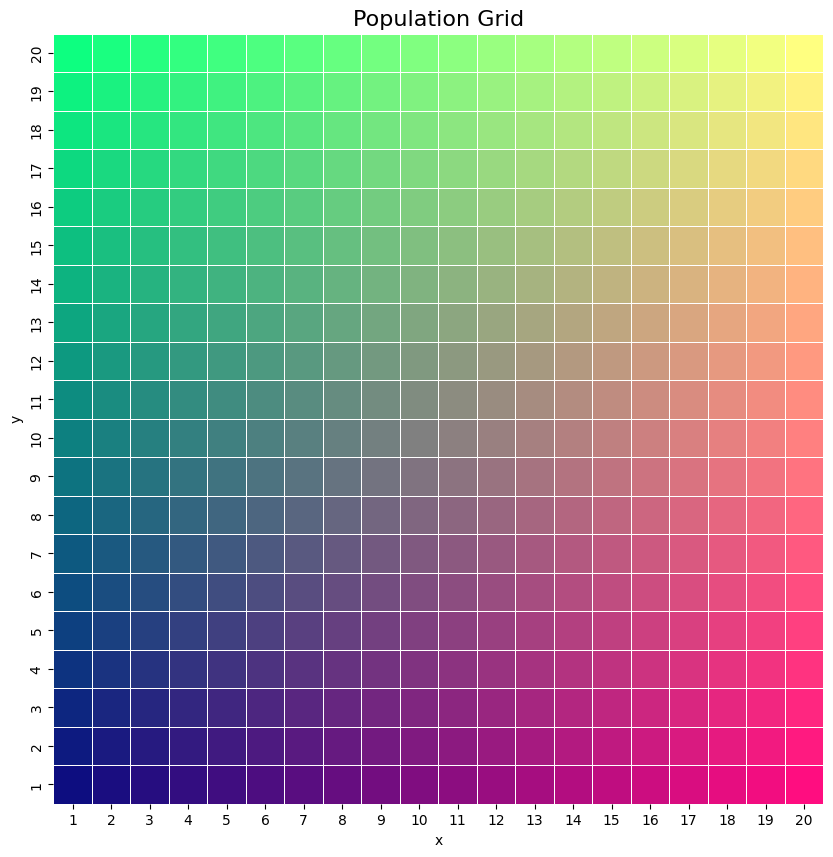

In [65]:
populations = pd.read_pickle(f"../data/phenotype/simulated_population_G{G}_L{L}_c{c}_k{k}_M{M}.pkl")
palette = [map_to_color(x, y, z, populations) for x, y, z in zip(populations['x'], populations['y'], populations['z'])]
populations['population'] = populations['populations'].str.extract('(\d+)').astype(int)
populations["population_number"] = populations['population']/populations['population'].max()
# Check the grid
df_agg = populations.groupby(['x', 'y']).agg({'population': 'mean'}).reset_index()

# Now, pivot the aggregated DataFrame
grid_df = df_agg.pivot(index='y', columns='x', values='population')

# Use seaborn to create the heatmap
plt.figure(figsize=(10, 10))
heatmap = sns.heatmap(grid_df, cmap=palette, linewidths=.5, square=True, cbar=False)

# Add a title to the heatmap
plt.title('Population Grid', fontsize=16)
plt.gca().invert_yaxis()  # Sometimes it's necessary to invert the y-axis for correct orientation
plt.show()

# Load data

In [66]:
geno = pd.read_pickle(f"../data/genotype/simulated_complete_genotypes_AF_0_0.5_G{G}_L{L}_c{c}_k{k}_M{M}.pkl")
AFs = pd.read_pickle(f"../data/genotype/simulated_complete_frequencies_AF_0_0.5_G{G}_L{L}_c{c}_k{k}_M{M}.pkl")
pheno = pd.read_pickle(f"../data/phenotype/simulatedcase_control_onlyenvrisk_{name_risk}_G{G}_L{L}_c{c}_k{k}_M{M}.pkl")
name_risk

'two_square_risk'

In [67]:
pheno

,two_square_risk,case_control_env
0,0.0,1
1,0.0,0
2,0.0,0
3,0.0,1
4,0.0,0
...,...,...
19995,0.0,1
19996,0.0,0
19997,0.0,0
19998,0.0,1


# Step by step AE

# Create model

In [68]:
#temp = pheno[['case_control_env']]
#for snp in list(geno.columns):
#    temp[snp] = list(pheno['case_control_env'])

In [69]:
#temp = temp[list(geno.columns)]

In [70]:
geno  = geno-1

In [71]:
epochs = 2000

In [72]:
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras import Input, layers, Model, regularizers

# Assuming you have defined geno and pheno data
# Split the data into training and testing sets
X_train, X_test, y_train, y_test, pheno_train, pheno_test = train_test_split(geno, geno, pheno[[name_risk]], test_size=0.2, random_state=42)

# Define your regularization strength (lambda)
l2_lambda = 0.001  # Adjust this value as needed

# Define input layers
input_shape_geno = geno.shape[1:]
input_layer_geno = Input(shape=input_shape_geno, name='input_geno')

input_shape_pheno = pheno.shape[1:]
input_layer_pheno = Input(shape=input_shape_pheno, name='input_pheno')

# Define bottleneck size
bottle = 15
bottle_nr = bottle
size_layer_1 = int(round(input_shape_geno[0]) / 2)

# Create layers
encoder_init_1 = layers.Dense(bottle, 
                       activation="elu", 
                       name="encoder_init_1",
                       kernel_regularizer=regularizers.l2(l2_lambda))

decoder_init_2 = layers.Dense(input_shape_geno[0], 
                       activation="elu", 
                       name="decoder_init_2",
                       kernel_regularizer=regularizers.l2(l2_lambda))

predictor = layers.Dense(input_shape_pheno[0], 
                       activation="linear", 
                       name="predictor",
                       kernel_regularizer=regularizers.l2(l2_lambda))

# Define custom layer for element-wise trainable weights
class ElementWiseWeightsLayer(tf.keras.layers.Layer):
    def __init__(self, **kwargs):
        super(ElementWiseWeightsLayer, self).__init__(**kwargs)

    def build(self, input_shape):
        self.weight = self.add_weight(shape=(), initializer="ones", trainable=True, name="element_wise_weight")
        super(ElementWiseWeightsLayer, self).build(input_shape)

    def call(self, inputs):
        return inputs * self.weight

# Define encoder and decoder paths
bottle_neck = encoder_init_1(input_layer_geno)
allele_frequency_probability = decoder_init_2(bottle_neck)
y = predictor(allele_frequency_probability)

# Define the model
autoencoder = Model(inputs=input_layer_geno, outputs=[allele_frequency_probability, y], name="fishy")
# Extract the bottleneck layer
bottleneck_model = tf.keras.Model(inputs=autoencoder.input, outputs=autoencoder.get_layer('encoder_init_1').output)

# Compile the model
autoencoder.compile(optimizer='adam', loss=['mse', 'mse'], loss_weights=[1.0, 0.0])

# Define early stopping callback
early_stopping = callbacks.EarlyStopping(monitor='val_loss', patience=100, restore_best_weights=True)

# Train the model
history = autoencoder.fit(X_train, [X_train, pheno_train], epochs=epochs, batch_size=32, validation_data=(X_test, [X_test, pheno_test]), callbacks=[early_stopping], verbose=0)

# Evaluate the model
evaluation = autoencoder.evaluate(X_test, [y_test, pheno_test])


125/125 [==============================] - 0s 1ms/step - loss: 0.0846 - decoder_init_2_loss: 0.0607 - predictor_loss: 18.1000


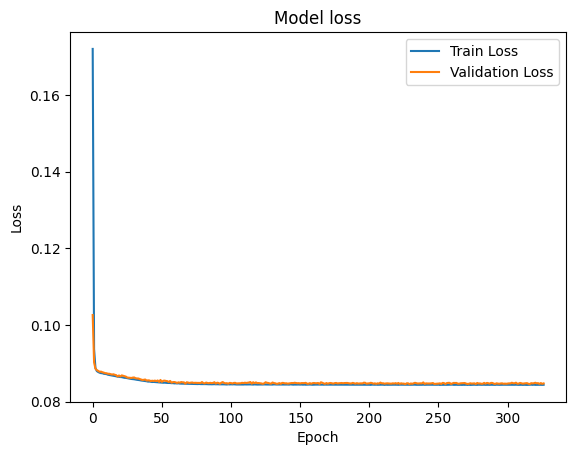

In [73]:
# Plot training & validation loss
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper right')
plt.show()

In [74]:
# Extracting the bottleneck layer, allele frequency probability, and predicted y for a given input
allele_frequency_output, y_output = autoencoder.predict(geno)

# bottleneck_output contains the output of the bottleneck layer
# allele_frequency_output contains the output of the allele frequency probability layer
# y_output contains the predicted output y

# If you want to inspect the shapes of these outputs:
#print("Bottleneck output shape:", bottleneck_output.shape)
print("Allele frequency probability output shape:", allele_frequency_output.shape)
print("Predicted y output shape:", y_output.shape)

625/625 [==============================] - 1s 1ms/step
Allele frequency probability output shape: (20000, 494)
Predicted y output shape: (20000, 2)


In [75]:
# Extract the first two hidden layers
hidden_layer_1 = autoencoder.get_layer('encoder_init_1')
#hidden_layer_2 = autoencoder.get_layer('encoder_init_2')
# Define input layer
input_layer = autoencoder.input

# Define the output of the first hidden layer
output_hidden_1 = hidden_layer_1(input_layer)

# Define the output of the second hidden layer
#output_hidden_2 = hidden_layer_2(output_hidden_1)

# Create a new model with only the first two hidden layers
new_model = tf.keras.Model(inputs=input_layer, outputs=output_hidden_1)

In [76]:
bottle = new_model.predict(geno)

625/625 [==============================] - 1s 954us/step


In [77]:
np.shape(bottle)

(20000, 15)

In [78]:
geno

,G1,G2,G3,G4,G5,G6,G7,G8,G9,G10,...,G491,G492,G493,G494,G495,G496,G497,G498,G499,G500
0,0.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,0.0,1.0
1,0.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,0.0,1.0
2,0.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,0.0,1.0
3,0.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,0.0,1.0
4,0.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19995,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,0.0,...,1.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,1.0
19996,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,0.0,...,1.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,1.0
19997,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,0.0,...,1.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,1.0
19998,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,0.0,...,1.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,1.0


In [79]:
y_output

array([[-5.7505184e-34, -4.9796374e-32],
       [-5.7505184e-34, -4.9796374e-32],
       [-5.7505184e-34, -4.9796374e-32],
       ...,
       [ 5.9898696e-33, -5.3227812e-32],
       [ 5.9898725e-33, -5.3227818e-32],
       [ 5.9898725e-33, -5.3227818e-32]], dtype=float32)

In [80]:
pheno

,two_square_risk,case_control_env
0,0.0,1
1,0.0,0
2,0.0,0
3,0.0,1
4,0.0,0
...,...,...
19995,0.0,1
19996,0.0,0
19997,0.0,0
19998,0.0,1


In [81]:
dim_labels = [f"dim{i}" for i in range(1, bottle_nr + 1)]

bottle_df = pd.DataFrame(data=bottle, columns=dim_labels)
to_have_collumns = ['populations','population_number', 'x', 'y','z','population']
bottle_df[to_have_collumns] = populations[to_have_collumns]
bottle_df['pheno'] = list(pheno["case_control_env"])

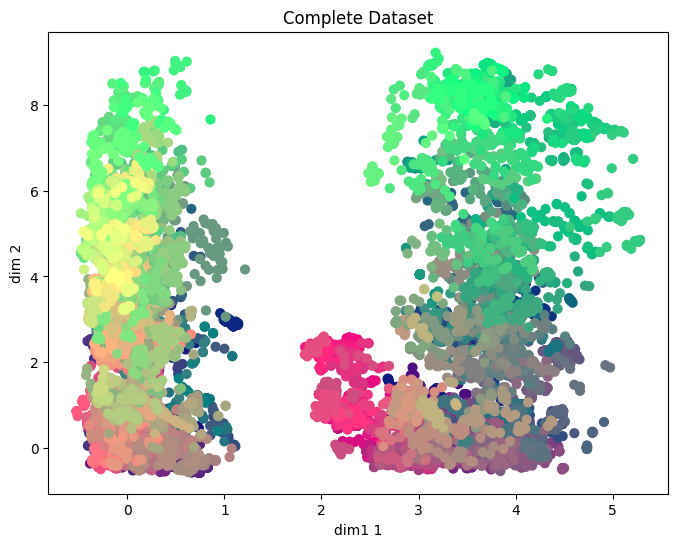

In [82]:
import matplotlib.pyplot as plt

# Create a figure
plt.figure(figsize=(8, 6))

# Count the unique values in the 'populations' column
unique_populations = bottle_df['populations'].nunique()

# Plotting the principal components with colors
colors = [map_to_color(x, y, z, bottle_df) for x, y, z in zip(bottle_df['x'], bottle_df['y'], bottle_df['z'])]
plt.scatter(x=bottle_df['dim1'], y=bottle_df['dim2'], c=colors, s=40)

plt.title('Complete Dataset')  # Set the title for the plot
plt.xlabel('dim1 1')
plt.ylabel('dim 2')

# Only show the legend if there are 16 or fewer unique populations
if unique_populations <= 16:
    plt.legend(title='Population', bbox_to_anchor=(1.05, 1), loc='upper left')
else:
    plt.legend([], [], frameon=False)  # This hides the legend

# Show the plot
plt.show()

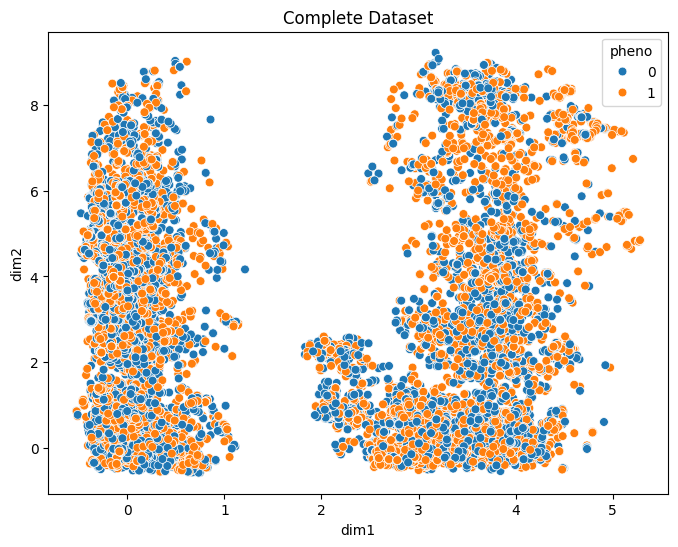

In [83]:
import seaborn as sns
import matplotlib.pyplot as plt

# Create a figure
plt.figure(figsize=(8, 6))

# Plotting the principal components with colors based on 'pheno'
sns.scatterplot(data=bottle_df, x='dim1', y='dim2', hue='pheno', s=40)

plt.title('Complete Dataset')  # Set the title for the plot
plt.xlabel('dim1')
plt.ylabel('dim2')

# Show the plot
plt.show()


In [84]:
probmaf = (pd.DataFrame(data=allele_frequency_output, columns = geno.columns)+1)/2
probmaf = 1-probmaf
probmaf.to_pickle(f"../data/estimated p values/estimated_af_deep_G{G}_L{L}_c{c}_k{k}_M{M}.pkl")


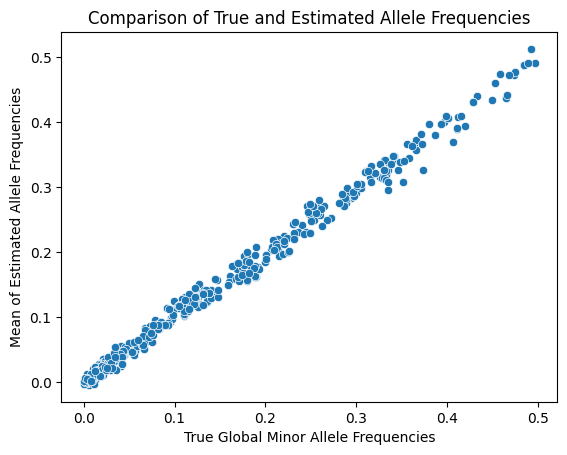

In [85]:
estimated_AF = probmaf.mean(axis=0)
sns.scatterplot(x=list(AFs['AFs']), y=list(estimated_AF))
plt.xlabel('True Global Minor Allele Frequencies')
plt.ylabel('Mean of Estimated Allele Frequencies')
plt.title('Comparison of True and Estimated Allele Frequencies')
plt.show()

In [86]:
pheno

,two_square_risk,case_control_env
0,0.0,1
1,0.0,0
2,0.0,0
3,0.0,1
4,0.0,0
...,...,...
19995,0.0,1
19996,0.0,0
19997,0.0,0
19998,0.0,1


In [87]:
pheno['predicted'] = list(pd.DataFrame(y_output).mean(axis=1))
correlation = pheno['case_control_env'].corr(pheno['predicted'])
print("Correlation between column1 and column2:", correlation)

Correlation between column1 and column2: 0.03277638813868237


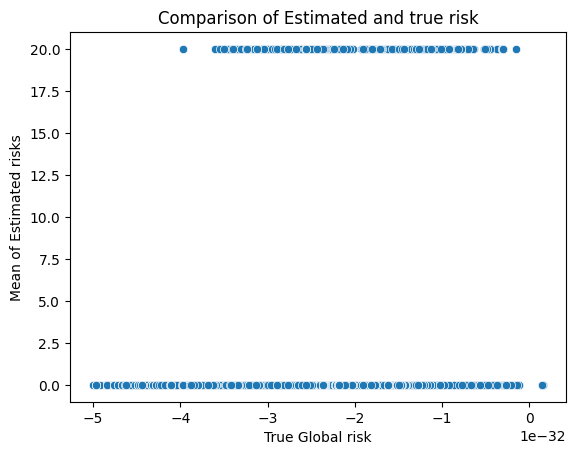

In [88]:
sns.scatterplot(x=list(pd.DataFrame(y_output).mean(axis=1)), y=list(pheno[name_risk]))
plt.xlabel('True Global risk')
plt.ylabel('Mean of Estimated risks')
plt.title('Comparison of Estimated and true risk')
plt.show()